In [1]:
import cv2
import os
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

ROOT_DIR = os.path.abspath(os.path.join('../../../'))
print('Root directory:',ROOT_DIR)
sys.path.append(ROOT_DIR)
sys.path.append(os.path.abspath(os.path.join('../..')))

from mrcnn import visualize
from mrcnn import utils

from bep.utils import load_train_val_datasets, get_ax

figsize = 25
image_count = 1
threshold = 2000

Root directory: c:\Users\abell\Documents\aa_delft\J4\BEP\ai
Root directory: c:\Users\abell\Documents\aa_delft\J4\BEP\ai


In [2]:
data, _, _ = load_train_val_datasets(ROOT_DIR)

**Original Image**

In [21]:
data.image_info[0]

{'id': 1,
 'source': 'ali',
 'path': 'c:\\Users\\abell\\Documents\\aa_delft\\J4\\BEP\\ai\\data\\images\\train\\08_sio2_NbSe2_Done_f1_img.png',
 'width': 3088,
 'height': 2076,
 'annotations': [{'id': 42,
   'image_id': '08_sio2_NbSe2_Done_f1_img.png',
   'category_id': 3,
   'segmentation': [[1888.631,
     1045.87,
     1898.631,
     1062.87,
     1905.631,
     1079.87,
     1912.131,
     1091.87,
     1919.631,
     1102.87,
     1922.631,
     1109.87,
     1911.631,
     1104.37,
     1901.131,
     1099.87,
     1894.631,
     1095.37,
     1887.631,
     1086.37,
     1880.631,
     1075.87,
     1878.631,
     1065.37,
     1888.631,
     1045.87]],
   'area': 2816.0,
   'bbox': [1878.631, 1045.87, 44.0, 64.0],
   'iscrowd': 0,
   'source': 'ali'}]}

[{'id': 22, 'source': 'ali', 'path': 'c:\\Users\\abell\\Documents\\aa_delft\\J4\\BEP\\ai\\data\\images\\train\\67_sio2_NbSe2_Exfoliation_B2-31_f1_img.png', 'width': 3088, 'height': 2076, 'annotations': [{'id': 61, 'image_id': '67_sio2_NbSe2_Exfoliation_B2-31_f1_img.png', 'category_id': 2, 'segmentation': [[1695.688, 1539.688, 1687.188, 1542.438, 1679.688, 1544.938, 1678.438, 1549.688, 1681.938, 1553.938, 1691.188, 1557.938, 1696.188, 1555.688, 1696.688, 1552.438, 1698.438, 1545.813, 1695.688, 1539.688]], 'area': 365.0, 'bbox': [1678.438, 1539.688, 20.0, 18.25], 'iscrowd': 0, 'source': 'ali'}, {'id': 62, 'image_id': '67_sio2_NbSe2_Exfoliation_B2-31_f1_img.png', 'category_id': 3, 'segmentation': [[1696.105, 1555.688, 1696.772, 1552.022, 1698.522, 1545.855, 1695.688, 1539.688, 1696.772, 1532.522, 1700.522, 1531.355, 1703.438, 1539.938, 1704.938, 1548.688, 1706.272, 1556.105, 1706.938, 1563.522, 1707.022, 1568.605, 1706.522, 1570.855, 1696.272, 1567.022, 1687.605, 1563.272, 1682.272, 1562.

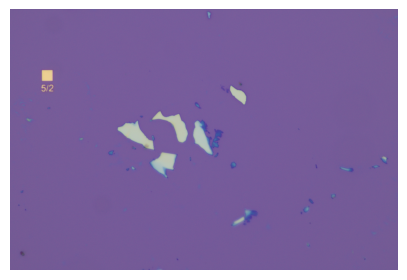

In [4]:
possible_images = [i for i in data.image_info if '67' in i['path']]
print(possible_images)

image_id = 22

image = cv2.imread(data.image_info[image_id]['path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

**Create background**

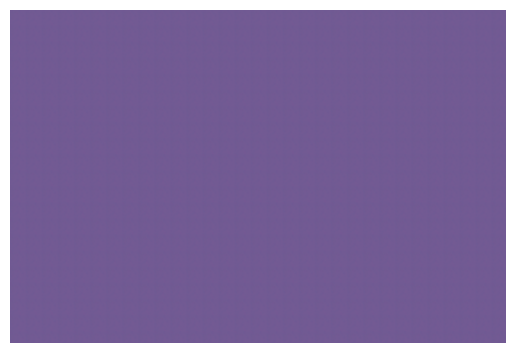

In [5]:
sample_image_path = os.path.join(ROOT_DIR, 'data', 'images', 'batch4', '67_sio2_NbSe2_Exfoliation_C5-84_f4_img.png')
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

square_size = 100
small_square = cv2.GaussianBlur(sample_image[:square_size, :square_size], (15,15), 0)

tile_height, tile_width = small_square.shape[:2]
num_tiles_y = image.shape[0] // tile_height + 1
num_tiles_x = image.shape[1] // tile_width + 1
tiled_background = np.tile(small_square, (num_tiles_y, num_tiles_x, 1))[:sample_image.shape[0], :sample_image.shape[1], :]
tiled_background = cv2.GaussianBlur(tiled_background, (11, 11), 0)

plt.figure()
plt.imshow(tiled_background)
plt.axis('off')
plt.show()

**Fill background with sample**

In [6]:
len(data.image_info[image_id]['annotations'])

20

In [7]:

annotations_file = os.path.join(ROOT_DIR, 'data', 'annotations', 'batchsplit.json')

annotations_dict = {
    "info": {
        "year": 2024,
        "description": "",
        "version": 1.0,
        "date_created": "",
        "url": "tudelft.nl",
        "contributor": "Abel de Lange"
    }, 
    "categories": [
        {"id": 1, "name": "Mono_NbSe2"},
        {"id": 2, "name": "Few_NbSe2"},
        {"id": 3, "name": "Thick_NbSe2"}
    ],
    "annotations": [],
    "images": []
}

border = 10

for idx, annotation in enumerate(data.image_info[image_id]['annotations']):
    bbox = annotation['bbox']
    x, y, w, h = [int(i) for i in bbox]

    area = w*h

    # if area < threshold:
    #     continue

    flake_image = tiled_background.copy()
    flake_image = cv2.GaussianBlur(flake_image, (11, 11), 0)
    flake_image[y-border:y+h+border, x-border:x+w+border] = image[y-border:y+h+border, x-border:x+w+border]

    filename = data.image_info[image_id]['path'].split('\\')[-1].split('.')[0] + f'_split_{idx}' + '.png'

    flake_annotation = annotation.copy()
    flake_annotation['image_id'] = filename
    flake_annotation['id'] = int('{}{}'.format(flake_annotation['id'], idx))
    annotations_dict['annotations'].append(flake_annotation)
    annotations_dict['images'].append({
        "id": int('{}{}'.format(image_id, idx)),
        "path": os.path.join(ROOT_DIR, 'data', 'images', 'split', filename),
        "file_name": filename,
        "width": sample_image.shape[1],
        "height": sample_image.shape[0],
        "date_captured": "",
        "license": 1,
        "coco_url": "",
        "flickr_url": ""
    })

    # plt.figure(figsize=(10, 10))
    # plt.imshow(flake_image)
    # plt.axis('off')  # Hide axis
    # plt.show()

    cv2.imwrite(os.path.join(ROOT_DIR, 'data', 'images', 'split', filename), cv2.cvtColor(flake_image, cv2.COLOR_RGB2BGR))

with open(annotations_file, 'w+') as f:
    json.dump(annotations_dict, f)
